In [1]:
import os

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten 
import tensorflow as tf

In [3]:
import cv2
import numpy as np

In [4]:
def normalize_data(file_path):
    '''
    To reduce the domain of each features in the image
    from 0->255(tf.uint8) to 0->1(tf.float)
    '''
    # byte image
    byte_image = tf.io.read_file(file_path)

    # numpy image
    image = tf.io.decode_jpeg(byte_image)

    # Feature normalize data
    image = image / 255

    return image

In [5]:
# File path definition
# Note: For multiclass classification new variables
# for respective file path must be created
CURRENT_DIRECTORY_ABS_PATH = os.path.abspath(os.getcwd())
LABEL1 = r"Classes\Thiyaneswar"
LABEL1_PATH = os.path.join(CURRENT_DIRECTORY_ABS_PATH, LABEL1)
ANCHOR1_PATH = os.path.join(CURRENT_DIRECTORY_ABS_PATH, r"Anchor\Thiyaneswar")
NEGATIVE_PATH = os.path.join(CURRENT_DIRECTORY_ABS_PATH, "Negatives")

In [6]:
# Load dataset from directory
anchor1 = tf.data.Dataset.list_files(ANCHOR1_PATH + r"\*.jpg").take(700)
positive1 = tf.data.Dataset.list_files(LABEL1_PATH + r"\*.jpg").take(700)
negative = tf.data.Dataset.list_files(NEGATIVE_PATH + r"\*.jpg").take(700)

In [7]:
# Labelling data
positive_labels = tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor1)))
negative_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(negative)))

positives = tf.data.Dataset.zip((anchor1, positive1, positive_labels))
negatives = tf.data.Dataset.zip((anchor1, negative, negative_labels))
data_set = positives.concatenate(negatives)

In [8]:
# Preprocess data
preprocess_data = lambda image_input, image_validate, label: (normalize_data(image_input), normalize_data(image_validate), label)

data_set = data_set.map(preprocess_data)
data_set = data_set.cache()
data_set = data_set.shuffle(buffer_size = 2048)

In [9]:
data = data_set.as_numpy_iterator()
data.next()[0].shape

(105, 105, 3)

In [10]:
BATCH = 4
PRE_FETCH = 2

In [11]:
# Train data
TRAINING_PERCENTAGE = 0.8
TRAINING_SAMPLE_SIZE = int(len(data_set) * TRAINING_PERCENTAGE)
train_data = data_set.take(TRAINING_SAMPLE_SIZE)
train_data = train_data.batch(BATCH)
train_data = train_data.prefetch(PRE_FETCH)

# Test data
TESTING_PERCENTAGE = 0.2
test_data = data_set.skip(TRAINING_SAMPLE_SIZE)
test_data = test_data.batch(BATCH)
test_data = test_data.prefetch(PRE_FETCH)

In [14]:
def model_encoding():
    input_layer = Input(shape = (105, 105, 3), name = 'input_image')

    conv_layer_1 = Conv2D(64, (10, 10), activation = 'relu')(input_layer)
    max_pooling_1 = MaxPooling2D(64, (2, 2), padding = 'same')(conv_layer_1) 

    conv_layer_2 = Conv2D(128, (7, 7), activation = 'relu')(max_pooling_1)
    max_pooling_2 = MaxPooling2D(64, (2, 2), padding = 'same')(conv_layer_2) 

    conv_layer_3 = Conv2D(128, (4, 4), activation = 'relu')(max_pooling_2)
    max_pooling_3 = MaxPooling2D(64, (2, 2), padding = 'same')(conv_layer_3) 

    conv_layer_4 = Conv2D(256, (4, 4), activation = 'relu')(input_layer)
    flatten_layer = Flatten()(conv_layer_4)
    dense_layer = Dense(4096, activation = 'sigmoid')(flatten_layer)

    return Model(inputs = [input_layer], outputs = [dense_layer], name = 'encoding') 

In [ ]:
# Encoding
# encoding = model_encoding()
# encoding.summary()

In [12]:
class L1Distance(tf.keras.layers.Layer):
    # Custom distance class to find the distance between
    # validation and input images
    def __init__(self, *args, **kwargs):
        super().__init__()

    def call(self, encoded_input_image, encoded_validation_image):
        return tf.math.abs(encoded_input_image - encoded_validation_image)

In [17]:
def create_siamese_model():
    input_image = Input(name = 'input_image', shape = (105, 105, 3))

    validation_image = Input(name = 'validation_image', shape = (105, 105, 3))

    siamese_layer = L1Distance()
    siamese_layer._name = 'distance'

    distance = siamese_layer(encoding(input_image), encoding(validation_image))

    classifier = Dense(1, activation = 'sigmoid')(distance)

    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'siamese_network')

ERROR! Session/line number was not unique in database. History logging moved to new session 29


In [ ]:
siamese_model = create_siamese_model()

In [ ]:
siamese_model.summary()

In [ ]:
loss_function = tf.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(1e-5)

In [ ]:
checkpoint_directory = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_directory, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=optimizer, siamese_model=siamese_model)

In [ ]:
@tf.function
def step(batch):

    with tf.GradientTape() as tape:
        X = batch[: 2]
        y = batch[2]

        y_prediction = siamese_model(X, training = True)
        loss = loss_function(y, y_prediction)

    gradient = tape.gradient(loss, siamese_model.trainable_variables)

    optimizer.apply_gradients(zip(gradient, siamese_model.trainable_variables))

    return loss

In [13]:
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
def training(data, num_epochs):
    for num_epoch in range(1, num_epochs + 1, 1):
        print(f'Epoch competed {num_epoch}/{num_epochs}')

        progress_bar = tf.keras.utils.Progbar(len(data))

        recall = Recall()
        precision = Precision()

        for index, batch in enumerate(data):

            loss = step(batch)
            y_prediction = siamese_model.predict(batch[: 2])
            recall.update_state(batch[2], y_prediction)
            precision.update_state(batch[2], y_prediction)
            progress_bar.update(index + 1)

        if num_epochs % 4 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
num_epochs = 20

In [ ]:
# training(train_data, num_epochs=num_epochs)

In [25]:
test_input, test_validate, label = test_data.as_numpy_iterator().next() 

In [15]:
model = tf.keras.models.load_model('face.h5', custom_objects = {'L1Distance': L1Distance})

In [26]:
prediction = model.predict([test_input, test_validate])

In [17]:
model.summary()

Model: "siamese_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoding (Functional)          (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[

In [27]:
prediction > 0.5

array([[False],
       [ True],
       [False],
       [ True]])

In [19]:
import matplotlib.pyplot as plt

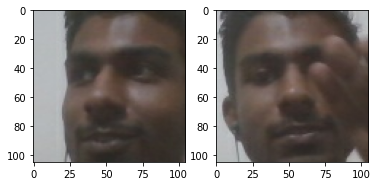

In [32]:
plt.subplot(1, 2, 1)
plt.imshow(test_input[3])

plt.subplot(1, 2, 2)
plt.imshow(test_validate[3])

plt.show()

In [24]:
test_input.shape

(4, 105, 105, 3)